In [1]:
import numpy as np
import pandas as pd

CLASSES= ["Bull","Bear"]
LABEL_BULL= CLASSES.index("Bull")
LABEL_BEAR= CLASSES.index("Bear")

datasets= np.load("datasetsTSLA.npz")

x_train, y_train= datasets["x_train"], datasets["y_train"]
x_val, y_val= datasets["x_val"], datasets["y_val"]
x_test, y_test= datasets["x_test"], datasets["y_test"]


label_distribution = pd.DataFrame([{"Dataset": "train",
                                    "BULL": np.count_nonzero(y_train == LABEL_BULL),
                                   "BEAR": np.count_nonzero(y_train == LABEL_BEAR)},
                                  {"Dataset": "val",
                                    "BULL": np.count_nonzero(y_val == LABEL_BULL),
                                   "BEAR": np.count_nonzero(y_val == LABEL_BEAR)},
                                   {"Dataset": "test",
                                    "BULL": np.count_nonzero(y_test == LABEL_BULL),
                                   "BEAR": np.count_nonzero(y_test == LABEL_BEAR)}])

In [2]:
label_distribution

,Dataset,BULL,BEAR
0,train,881,809
1,val,246,237
2,test,112,112


In [3]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout 
from tensorflow.keras.layers import Concatenate, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def inception_module(input_tensor):
    bottleneck= Conv1D(filters=32,kernel_size=1,padding="same",
                      activation=None,use_bias=False)(input_tensor)
    conv3= Conv1D(filters=32,kernel_size=3,padding="same",
                      activation=None,use_bias=False)(bottleneck)
    conv5= Conv1D(filters=32,kernel_size=5,padding="same",
                      activation=None,use_bias=False)(bottleneck)
    conv7= Conv1D(filters=32,kernel_size=7,padding="same",
                      activation=None,use_bias=False)(bottleneck)
    mp= MaxPooling1D(pool_size=3,strides=1,padding="same")(input_tensor)
    mpbottleneck= Conv1D(filters=32,kernel_size=1,padding="same",
                      activation=None,use_bias=False)(mp)
    
    x= Concatenate(axis=-1)([conv3,conv5,conv7,mpbottleneck])
    x= BatchNormalization()(x)
    x= Activation("LeakyReLU")(x)
    
    return x

def shortcut_layer(input_tensor1, input_tensor2):
    shortcut= Conv1D(filters=input_tensor2.shape[-1],kernel_size=1,padding="same",
                      activation=None,use_bias=False)(input_tensor1)
    shortcut= BatchNormalization()(shortcut)
    
    x= Add()([shortcut,input_tensor2])
    x= Activation("LeakyReLU")(x)
    
    return x

# build model

n_time_steps= x_train.shape[1]
n_features= x_train.shape[2]

input_layer= Input(shape=(n_time_steps,n_features))
x= input_layer
input_residual= input_layer

for i in range(6):
    x= inception_module(x)
    x= Dropout(0.2)(x)
    
    if i % 3 == 2:
        x= shortcut_layer(input_residual, x)
        input_residual= x

x= GlobalAveragePooling1D()(x)
output_layer= Dense(len(CLASSES),activation="softmax")(x)

model= Model(inputs= input_layer, outputs= output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 32)      160         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 100, 5)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 100, 32)      3072        ['conv1d[0][0]']                 
                                                                                              

                                                                  'dropout_2[0][0]']              
                                                                                                  
 activation_3 (Activation)      (None, 100, 128)     0           ['add[0][0]']                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 100, 32)      4096        ['activation_3[0][0]']           
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 100, 128)    0           ['activation_3[0][0]']           
                                                                                                  
 conv1d_17 (Conv1D)             (None, 100, 32)      3072        ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_18

                                                                                                  
 activation_7 (Activation)      (None, 100, 128)     0           ['add_1[0][0]']                  
                                                                                                  
 global_average_pooling1d (Glob  (None, 128)         0           ['activation_7[0][0]']           
 alAveragePooling1D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 2)            258         ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
Total params: 154,818
Trainable params: 152,770
Non-trainable params: 2,048
_________________________________

In [4]:
# train moddel
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss= "categorical_crossentropy", optimizer= "adam",
             metrics= ["accuracy"])

train_label_counts= label_distribution.iloc[0]

class_weight= {LABEL_BULL:1., LABEL_BEAR:train_label_counts["BULL"] / train_label_counts["BEAR"]}
reduce_1r= ReduceLROnPlateau(monitor="val_loss", factor= 0.2, patience= 30, min_1r= 0.00001)

model_checkpoint= ModelCheckpoint(filepath="best_modelTSLA.hdf5",
                                 monitor="val_loss",
                                 save_best_only=True)
early_stopping= EarlyStopping(monitor="val_loss",patience=100,
                             restore_best_weights=True)
callbacks= [reduce_1r, model_checkpoint, early_stopping]

train_history= model.fit(x_train, to_categorical(y_train),
                        class_weight= class_weight,
                        validation_data= (x_val, to_categorical(y_val)),
                        batch_size= 2048, epochs= 1000, callbacks= [callbacks])

Epoch 1/1000
1/1 [==============================] - 17s 17s/step - loss: 1.0005 - accuracy: 0.5237 - val_loss: 12.2886 - val_accuracy: 0.4907 - lr: 0.0010
Epoch 2/1000
1/1 [==============================] - 9s 9s/step - loss: 0.9575 - accuracy: 0.4994 - val_loss: 2.6573 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 3/1000
1/1 [==============================] - 8s 8s/step - loss: 0.8126 - accuracy: 0.5213 - val_loss: 12.8174 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 4/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7769 - accuracy: 0.5207 - val_loss: 13.4302 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 5/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7615 - accuracy: 0.5249 - val_loss: 8.7679 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 6/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7261 - accuracy: 0.5243 - val_loss: 3.2327 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 7/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7402 - acc

1/1 [==============================] - 9s 9s/step - loss: 0.7181 - accuracy: 0.5491 - val_loss: 0.7127 - val_accuracy: 0.4948 - lr: 2.0000e-04
Epoch 107/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7169 - accuracy: 0.5331 - val_loss: 0.7112 - val_accuracy: 0.4969 - lr: 2.0000e-04
Epoch 108/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7195 - accuracy: 0.5302 - val_loss: 0.7107 - val_accuracy: 0.5010 - lr: 2.0000e-04
Epoch 109/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7179 - accuracy: 0.5379 - val_loss: 0.7109 - val_accuracy: 0.5093 - lr: 2.0000e-04
Epoch 110/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7145 - accuracy: 0.5479 - val_loss: 0.7118 - val_accuracy: 0.5072 - lr: 2.0000e-04
Epoch 111/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7151 - accuracy: 0.5515 - val_loss: 0.7125 - val_accuracy: 0.5031 - lr: 2.0000e-04
Epoch 112/1000
1/1 [==============================] - 9s 9s/step - 

Epoch 158/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7160 - accuracy: 0.5373 - val_loss: 0.6988 - val_accuracy: 0.5176 - lr: 2.0000e-04
Epoch 159/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7164 - accuracy: 0.5473 - val_loss: 0.6980 - val_accuracy: 0.5238 - lr: 2.0000e-04
Epoch 160/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7152 - accuracy: 0.5538 - val_loss: 0.6975 - val_accuracy: 0.5259 - lr: 2.0000e-04
Epoch 161/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7160 - accuracy: 0.5491 - val_loss: 0.6971 - val_accuracy: 0.5300 - lr: 2.0000e-04
Epoch 162/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7160 - accuracy: 0.5580 - val_loss: 0.6966 - val_accuracy: 0.5238 - lr: 2.0000e-04
Epoch 163/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7143 - accuracy: 0.5503 - val_loss: 0.6966 - val_accuracy: 0.5238 - lr: 2.0000e-04
Epoch 164/1000
1/1 [==============================] 

Epoch 210/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7134 - accuracy: 0.5479 - val_loss: 0.6927 - val_accuracy: 0.5342 - lr: 2.0000e-04
Epoch 211/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7149 - accuracy: 0.5396 - val_loss: 0.6931 - val_accuracy: 0.5321 - lr: 2.0000e-04
Epoch 212/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7161 - accuracy: 0.5426 - val_loss: 0.6932 - val_accuracy: 0.5321 - lr: 2.0000e-04
Epoch 213/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7137 - accuracy: 0.5533 - val_loss: 0.6929 - val_accuracy: 0.5342 - lr: 2.0000e-04
Epoch 214/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7138 - accuracy: 0.5521 - val_loss: 0.6922 - val_accuracy: 0.5300 - lr: 2.0000e-04
Epoch 215/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7152 - accuracy: 0.5503 - val_loss: 0.6916 - val_accuracy: 0.5321 - lr: 2.0000e-04
Epoch 216/1000
1/1 [==============================] 

Epoch 262/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7145 - accuracy: 0.5367 - val_loss: 0.6922 - val_accuracy: 0.5321 - lr: 2.0000e-04
Epoch 263/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7138 - accuracy: 0.5473 - val_loss: 0.6919 - val_accuracy: 0.5300 - lr: 2.0000e-04
Epoch 264/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7127 - accuracy: 0.5538 - val_loss: 0.6922 - val_accuracy: 0.5342 - lr: 2.0000e-04
Epoch 265/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7135 - accuracy: 0.5497 - val_loss: 0.6929 - val_accuracy: 0.5342 - lr: 2.0000e-04
Epoch 266/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7120 - accuracy: 0.5485 - val_loss: 0.6944 - val_accuracy: 0.5321 - lr: 2.0000e-04
Epoch 267/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7123 - accuracy: 0.5627 - val_loss: 0.6959 - val_accuracy: 0.5197 - lr: 2.0000e-04
Epoch 268/1000
1/1 [==============================] 

Epoch 314/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7145 - accuracy: 0.5491 - val_loss: 0.6967 - val_accuracy: 0.5362 - lr: 4.0000e-05
Epoch 315/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7124 - accuracy: 0.5462 - val_loss: 0.6968 - val_accuracy: 0.5383 - lr: 8.0000e-06
Epoch 316/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7151 - accuracy: 0.5444 - val_loss: 0.6968 - val_accuracy: 0.5383 - lr: 8.0000e-06
Epoch 317/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7122 - accuracy: 0.5527 - val_loss: 0.6969 - val_accuracy: 0.5383 - lr: 8.0000e-06
Epoch 318/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7136 - accuracy: 0.5580 - val_loss: 0.6968 - val_accuracy: 0.5342 - lr: 8.0000e-06
Epoch 319/1000
1/1 [==============================] - 8s 8s/step - loss: 0.7131 - accuracy: 0.5586 - val_loss: 0.6968 - val_accuracy: 0.5342 - lr: 8.0000e-06
Epoch 320/1000
1/1 [==============================] 

Text(0.5, 0, 'epoch')

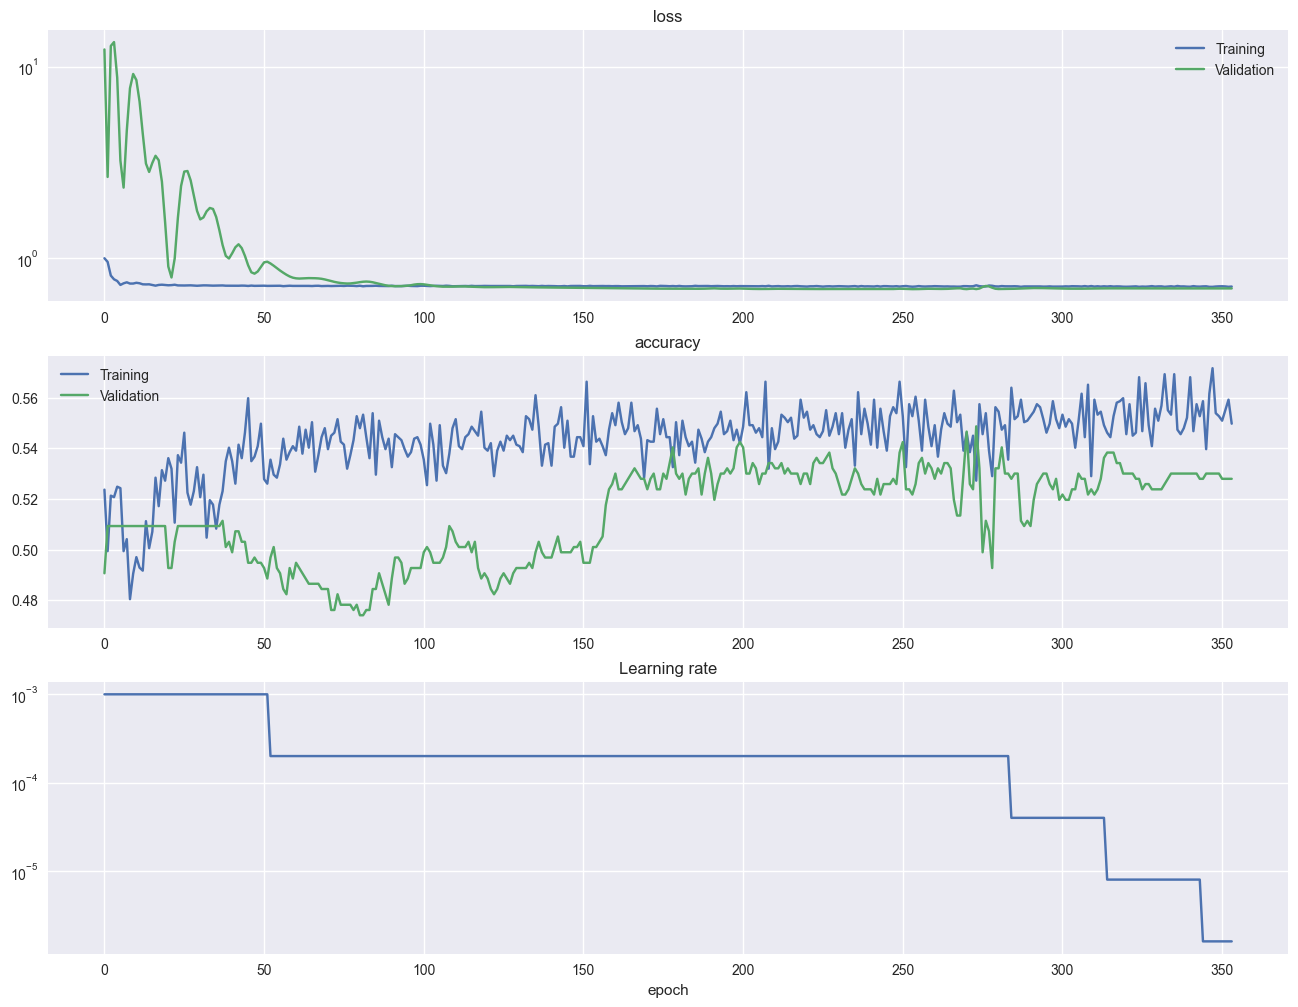

In [5]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, axes= plt.subplots(3,1, figsize= (16,12))

axes[0].set_title("loss")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label= "Training")
axes[0].plot(train_history.history["val_loss"], label= "Validation")
axes[0].legend()

axes[1].set_title("accuracy")
# axes[1].set_xlabel("epoch")
axes[1].plot(train_history.history["accuracy"], label= "Training")
axes[1].plot(train_history.history["val_accuracy"], label= "Validation")
axes[1].legend()

axes[2].set_title("Learning rate")
axes[2].set_yscale("log")
axes[2].plot(train_history.history["lr"])
axes[2].set_xlabel("epoch")